In [60]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')
import os


In [61]:
SYS.setrecursionlimit(150000)

In [62]:
from src.random_hamiltonian import random_unitary
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

from src import measurements as measure, density_matrix as DM

import time

In [106]:
def line_order(n):
    shift = rng.integers(n)
    return lambda:  np.roll(list(range(n)), shift)

def random_order(n):
    return lambda: rng.permutation(n)

def messenger_order_8(trial_index):
    orders1=[[0,1,2,3,4,5,6,7]]
    orders2= [[0,1,2,4,3,5,6,7]]
    if trial_index%2 ==0:
        return lambda: rng.choice(orders1)
    else:
         return lambda: rng.choice(orders2)

def messenger_order_12_type1_chunk_size_4():
    orders = [[0,1,2,3,4,5,6,7,8,9,10,11],[0,1,2,7,4,5,6,3,8,9,10,11],[0,1,2,3,4,5,6,11,8,9,10,7],[0,1,2,11,4,5,6,7,8,9,10,3]]
    return lambda: rng.choice(orders)

def messenger_order_12_type2_chunk_size_6():
    orders = [[0,1,2,3,4,5,6,7,8,9,10,11],[0,1,2,3,4,6,5,7,8,9,10,11]]
    return lambda: rng.choice(orders)

In [64]:
def run_n_trials(qm_sys: DM.DensityMatrix, num_blocks: int, measurment_set, num_trials: int, possible_orders):
    
    if type(measurment_set) != list:
        measurment_set = [measurment_set]
        
    
    
    start = time.time()
    N = qm_sys.number_of_qbits
    
    
    measurments = [np.array(measurment(qm_sys)) for measurment in measurment_set]

    assert N % num_blocks == 0, f"num_block = {num_blocks} must divide the size of the system {N}"
    block_size = N // num_blocks
    for i in range(num_trials):
        sub_system_unitaries = [random_unitary(block_size) for _ in range(num_blocks)]
        U = DM.tensor(sub_system_unitaries)

        # shift the order of the qbits

        order = possible_orders()

        U.relabel_basis(order)
        U.change_to_energy_basis()

        qm_sys = U * qm_sys * U.H

        
        measurments = [np.vstack((measurments[i], measurment(qm_sys)))  for i,measurment in enumerate(measurment_set)]
    print(f"{np.round(time.time() - start, 2)} seconds elapsed")
    return measurments

In [41]:
N = 4
num_blocks = 1
pops = [.1, .1, .1, .4]
my_sys = DM.n_thermal_qbits(pops)
my_sys.change_to_energy_basis()


In [54]:
results = run_n_trials(my_sys,num_blocks,[measure.pops,measure.extractable_work_of_each_qubit],5,random_order(4))

0.19 seconds elapsed


In [58]:
extractable_work = results[1]
pops = results[0]

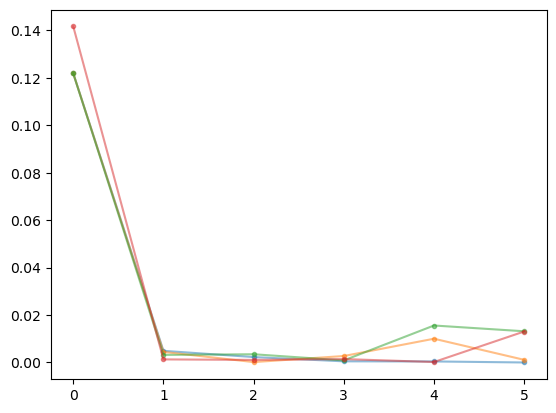

In [59]:
plt.plot(np.real(extractable_work),linestyle='-', marker='.',alpha = .5)
plt.show()

In [60]:
#this gets the change in work between each time step
change_in_work = extractable_work[1:]-extractable_work[:-1]

#this finds where the change in work is greater than zero (a larger cutoff can be used here to find more significant changes)
where_positive = change_in_work>0

#this gets where the change in work is positive for the ith qubit in time ordered manner
def change_in_work_Q_i(i):
    return change_in_work.real[0:,i]>0

#find the number of positive changes
num_positive_change = np.sum(where_positive)
print(num_positive_change)

#find the percent of positive changes
num_positive_change/(len(change_in_work)*N)

#find the number of positive changes across landscape for initially cold qubits
list_number_of_positive_for_initially_cold_qubits = [ sum(x) for x in zip(*where_positive)]
list_number_of_positive_for_initially_cold_qubits.pop(5)
print(list_number_of_positive_for_initially_cold_qubits)

#find the number of positive changes across landscape for initially hot qubits
print(sum(change_in_work_Q_i(5)))


6


IndexError: pop index out of range

In [26]:
#gives a list of intervals for each qubit i where change in work is positive
def intervals_length_for_Q_i(qubit):
    interval = [0]
    length = 0
    change_in_work_qubit = change_in_work_Q_i(qubit).tolist()
    change_in_work_qubit.append(0)
    for i in range(0,51):
        if change_in_work_qubit[i]==1:
            length = length +1
        else:
            interval.append(length)
            length = 0 
    return interval

In [29]:
#gives list of interval for which change in work is positive for the entire landscape
def all_intervals_on_landscape():
    all_intervals_on_landscape = []
    for i in range (0,N):
        all_intervals_on_landscape = all_intervals_on_landscape + intervals_length_for_Q_i(i)
    return all_intervals_on_landscape

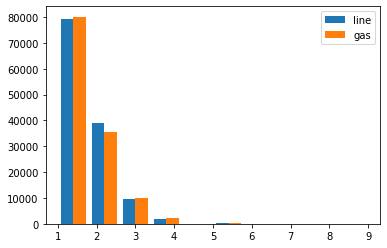

In [117]:
#plot histogram of interval lengths
plt.hist([all_intervals_on_landscape_connectivity(8,2,5,"line_with_one_uni"),all_intervals_on_landscape_connectivity(8,2,5,"gas_with_one_uni")],range=[1,9],label=("line","gas"))
plt.legend()
plt.show()

In [120]:
max(all_intervals_on_landscape_connectivity(8,2,5,"gas_with_one_uni"))

8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


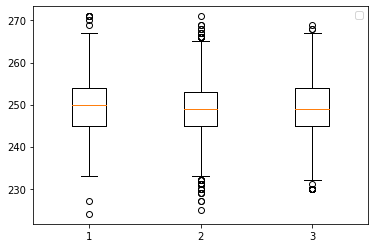

In [110]:
#creates boxplot for number of positive events for the initial hot vs cold qubit
plt.boxplot([total_num_positive_changes_for_initially_cold_qubits(8,2,4,"line"),total_num_positive_changes_for_initially_cold_qubits(8,2,4,"gas"),total_num_positive_changes_for_initially_cold_qubits(8,2,4,"mess")])
plt.legend()
plt.show()

In [107]:
def save_data(data:np.ndarray, num_qbits:str,measurment:str,num_chunks:str,connectivity_type:str,run_index:str,sim_index = int,extra = ""):
    index = 0
    if extra != "":
        path = f"../data/num_qbits={num_qbits}_num_chunks={num_chunks}_connectivity_type={connectivity_type}_other={extra}_index={sim_index}"
    else:
        path = f"../data/num_qbits={num_qbits}_num_chunks={num_chunks}_connectivity_type={connectivity_type}_index={sim_index}"
    if not os.path.exists(path):
        os.mkdir(path)
    file_name = path+f"/{measurment}_{run_index}.dat"
    np.savetxt(file_name,data,header=f"{measurment} for {num_qbits} qbits with connectivity {connectivity_type} in chunks {num_chunks}")

In [36]:
save_data(data = np.real(extractable_work),num_qbits = 12,measurment = "extractable_work",num_chunks = 2,connectivity_type = "messenger_qbit",run_index = 0)

In [85]:
N =8
trial_index_total = 500
num_chunks = 2
for index in range(3):
    print(f"working on the {index}th run")
    pops = [.2 for _ in range(8)]
    pops[5] = .4
    
    my_sys = DM.n_thermal_qbits(pops)
    my_sys.change_to_energy_basis()
    results = run_n_trials(my_sys,num_chunks,[measure.pops,measure.extractable_work_of_each_qubit],trial_index_total,messenger_order_8(trial_index))
    save_data(results[0], N, "pops" ,num_chunks,"line",index,0)
    save_data(results[1], N, "extractable_work",num_chunks,"line",index,0)

working on the 0th run
60.48 seconds elapsed
working on the 1th run
60.64 seconds elapsed
working on the 2th run
59.62 seconds elapsed
working on the 3th run
59.76 seconds elapsed
working on the 4th run
59.69 seconds elapsed
working on the 5th run
59.62 seconds elapsed
working on the 6th run
59.67 seconds elapsed
working on the 7th run
59.68 seconds elapsed
working on the 8th run
59.49 seconds elapsed
working on the 9th run
59.57 seconds elapsed
working on the 10th run
59.54 seconds elapsed
working on the 11th run
59.69 seconds elapsed
working on the 12th run
59.87 seconds elapsed
working on the 13th run
59.66 seconds elapsed
working on the 14th run
59.5 seconds elapsed
working on the 15th run
59.65 seconds elapsed
working on the 16th run
59.99 seconds elapsed
working on the 17th run
59.7 seconds elapsed
working on the 18th run
59.94 seconds elapsed
working on the 19th run
59.78 seconds elapsed
working on the 20th run
59.66 seconds elapsed
working on the 21th run
59.73 seconds elapsed


In [86]:
N =8
num_chunks = 2
for index in range(100):
    print(f"working on the {index}th run")
    pops = [.2 for _ in range(8)]
    pops[5] = .4
    
    my_sys = DM.n_thermal_qbits(pops)
    my_sys.change_to_energy_basis()
    results = run_n_trials(my_sys,num_chunks,[measure.pops,measure.extractable_work_of_each_qubit],500,line_order(N))
    save_data(results[0], N, "pops" ,num_chunks,"line",index,1)
    save_data(results[1], N, "extractable_work",num_chunks,"line",index,1)

working on the 0th run
61.84 seconds elapsed
working on the 1th run
61.52 seconds elapsed
working on the 2th run
61.42 seconds elapsed
working on the 3th run
61.22 seconds elapsed
working on the 4th run
61.32 seconds elapsed
working on the 5th run
61.38 seconds elapsed
working on the 6th run
61.29 seconds elapsed
working on the 7th run
61.49 seconds elapsed
working on the 8th run
61.42 seconds elapsed
working on the 9th run
61.35 seconds elapsed
working on the 10th run
61.38 seconds elapsed
working on the 11th run
61.12 seconds elapsed
working on the 12th run
61.31 seconds elapsed
working on the 13th run
61.3 seconds elapsed
working on the 14th run
61.51 seconds elapsed
working on the 15th run
61.36 seconds elapsed
working on the 16th run
61.34 seconds elapsed
working on the 17th run
61.26 seconds elapsed
working on the 18th run
61.47 seconds elapsed
working on the 19th run
61.32 seconds elapsed
working on the 20th run
61.23 seconds elapsed
working on the 21th run
61.32 seconds elapsed

In [87]:
N =8
num_chunks = 2
for index in range(100):
    print(f"working on the {index}th run")
    pops = [.2 for _ in range(8)]
    pops[5] = .4
    
    my_sys = DM.n_thermal_qbits(pops)
    my_sys.change_to_energy_basis()
    results = run_n_trials(my_sys,num_chunks,[measure.pops,measure.extractable_work_of_each_qubit],500,line_order(N))
    save_data(results[0], N, "pops" ,num_chunks,"line",index,2)
    save_data(results[1], N, "extractable_work",num_chunks,"line",index,2)

working on the 0th run
59.39 seconds elapsed
working on the 1th run
62.43 seconds elapsed
working on the 2th run
62.27 seconds elapsed
working on the 3th run
61.58 seconds elapsed
working on the 4th run
61.38 seconds elapsed
working on the 5th run
61.31 seconds elapsed
working on the 6th run
61.39 seconds elapsed
working on the 7th run
61.38 seconds elapsed
working on the 8th run
61.37 seconds elapsed
working on the 9th run
61.46 seconds elapsed
working on the 10th run
61.6 seconds elapsed
working on the 11th run
61.35 seconds elapsed
working on the 12th run
61.52 seconds elapsed
working on the 13th run
61.62 seconds elapsed
working on the 14th run
61.74 seconds elapsed
working on the 15th run
61.53 seconds elapsed
working on the 16th run
62.76 seconds elapsed
working on the 17th run
61.52 seconds elapsed
working on the 18th run
61.42 seconds elapsed
working on the 19th run
61.51 seconds elapsed
working on the 20th run
61.28 seconds elapsed
working on the 21th run
61.39 seconds elapsed

In [89]:
N =8
num_chunks = 2
for index in range(100):
    print(f"working on the {index}th run")
    pops = [.2 for _ in range(8)]
    pops[5] = .4
    
    my_sys = DM.n_thermal_qbits(pops)
    my_sys.change_to_energy_basis()
    results = run_n_trials(my_sys,num_chunks,[measure.pops,measure.extractable_work_of_each_qubit],500,line_order(N))
    save_data(results[0], N, "pops" ,num_chunks,"line",index,3)
    save_data(results[1], N, "extractable_work",num_chunks,"line",index,3)

working on the 0th run
61.3 seconds elapsed
working on the 1th run
61.32 seconds elapsed
working on the 2th run
61.45 seconds elapsed
working on the 3th run
61.52 seconds elapsed
working on the 4th run
61.46 seconds elapsed
working on the 5th run
61.37 seconds elapsed
working on the 6th run
61.57 seconds elapsed
working on the 7th run
61.29 seconds elapsed
working on the 8th run
61.31 seconds elapsed
working on the 9th run
61.38 seconds elapsed
working on the 10th run
61.34 seconds elapsed
working on the 11th run
61.31 seconds elapsed
working on the 12th run
61.34 seconds elapsed
working on the 13th run
61.42 seconds elapsed
working on the 14th run
61.36 seconds elapsed
working on the 15th run
61.31 seconds elapsed
working on the 16th run
61.25 seconds elapsed
working on the 17th run
61.31 seconds elapsed
working on the 18th run
61.26 seconds elapsed
working on the 19th run
61.55 seconds elapsed
working on the 20th run
61.44 seconds elapsed
working on the 21th run
61.35 seconds elapsed

In [88]:
N =8
num_chunks = 2
for index in range(100):
    print(f"working on the {index}th run")
    pops = [.2 for _ in range(8)]
    pops[5] = .4
    
    my_sys = DM.n_thermal_qbits(pops)
    my_sys.change_to_energy_basis()
    results = run_n_trials(my_sys,num_chunks,[measure.pops,measure.extractable_work_of_each_qubit],500,line_order(N))
    save_data(results[0], N, "pops" ,num_chunks,"line",index,4)
    save_data(results[1], N, "extractable_work",num_chunks,"line",index,4)

working on the 0th run
61.33 seconds elapsed
working on the 1th run
61.46 seconds elapsed
working on the 2th run
61.25 seconds elapsed
working on the 3th run
61.28 seconds elapsed
working on the 4th run
61.2 seconds elapsed
working on the 5th run
61.31 seconds elapsed
working on the 6th run
61.17 seconds elapsed
working on the 7th run
61.28 seconds elapsed
working on the 8th run
61.21 seconds elapsed
working on the 9th run
61.38 seconds elapsed
working on the 10th run
61.34 seconds elapsed
working on the 11th run
61.34 seconds elapsed
working on the 12th run
61.36 seconds elapsed
working on the 13th run
61.64 seconds elapsed
working on the 14th run
61.27 seconds elapsed
working on the 15th run
61.9 seconds elapsed
working on the 16th run
61.39 seconds elapsed
working on the 17th run
61.18 seconds elapsed
working on the 18th run
61.36 seconds elapsed
working on the 19th run
61.3 seconds elapsed
working on the 20th run
61.33 seconds elapsed
working on the 21th run
61.39 seconds elapsed
w

In [30]:
def extractable_work_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    index = sim_index
    trial = trial_index
    file_name = '../data/num_qbits={}_num_chunks={}_connectivity_type={}_index={}/extractable_work_{}.dat'.format(num_qbits,num_chunks,connectivity_type,sim_index,trial_index)
    return np.genfromtxt(file_name,dtype=np.complex64)
    

In [94]:
#this gets the change in work between each time step
def change_in_work_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    return extractable_work_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type)[1:]-extractable_work_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type)[:-1]

#this finds where the change in work is greater than zero (a larger cutoff can be used here to find more significant changes)
def where_positive_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    return change_in_work_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type)>0

#this gets where the change in work is positive for the ith qubit in time ordered manner
def change_in_work_Q_i_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type,qubit_num):
    return change_in_work_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type).real[0:,qubit_num]>0

#find the number of positive changes
def num_positive_change(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    np.sum(where_positive_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type))
    print(num_positive_change(num_qbits,num_chunks,sim_index,trial_index,connectivity_type))

#find the percent of positive changes
def percent_of_positive_changes(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    return num_positive_change(num_qbits,num_chunks,sim_index,trial_index,connectivity_type)/(len(change_in_work(num_qbits,num_chunks,sim_index,trial_index,connectivity_type))*N)

#find the number of positive changes across landscape for initially cold qubits
def list_number_of_positive_for_initially_cold_qubits(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    list_val = [sum(x) for x in zip(*where_positive_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type))]
    del list_val[5]
    return list_val

#find the number of positive changes across landscape for initially hot qubits
def number_positive_changes_across_landscape_for_initially_hot(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    return np.sum(change_in_work_Q_i_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type,5))

In [98]:
number_positive_changes_across_landscape_for_initially_hot(8,2,4,45,"gas")

246

In [113]:
#gives a list of intervals for each qubit i where change in work is positive
def intervals_length_for_Q_i(num_qbits,num_chunks,sim_index,trial_index,connectivity_type,qubit_num):
    interval = [0]
    length = 0
    change_in_work_qubit = change_in_work_Q_i_trial(num_qbits,num_chunks,sim_index,trial_index,connectivity_type,qubit_num).tolist()
    change_in_work_qubit.append(0)
    for i in range(0,100):
        if change_in_work_qubit[i]==1:
            length = length +1
        else:
            interval.append(length)
            length = 0 
    return interval

In [114]:
#gives list of interval for which change in work is positive for the entire landscape
def all_intervals_on_landscape(num_qbits,num_chunks,sim_index,trial_index,connectivity_type):
    all_intervals_on_landscape = []
    for qubit_num in range (0,num_qbits):
        all_intervals_on_landscape = all_intervals_on_landscape + intervals_length_for_Q_i(num_qbits,num_chunks,sim_index,trial_index,connectivity_type,qubit_num)
    return all_intervals_on_landscape

In [115]:
def all_intervals_on_landscape_connectivity(num_qbits,num_chunks,num_of_sims,connectivity_type):
    all_interval_on_line = []
    for sim_index in range (0,num_of_sims):
        for trial_index in range (0,100):
            all_interval_on_line = all_interval_on_line + all_intervals_on_landscape(num_qbits,num_chunks,sim_index,trial_index,connectivity_type)
    return all_interval_on_line        

In [116]:
def total_num_positive_changes_for_initially_cold_qubits(num_qbits,num_chunks,num_of_sims,connectivity_type):
    total_num_positive_changes_for_cold_qubits = []
    for sim_index in range (0,num_of_sims):
        for trial_index in range (0,100):
             total_num_positive_changes_for_cold_qubits =  total_num_positive_changes_for_cold_qubits + list_number_of_positive_for_initially_cold_qubits(num_qbits,num_chunks,sim_index,trial_index,connectivity_type)
    return  total_num_positive_changes_for_cold_qubits  

In [102]:
total_num_positive_changes_for_initially_cold_qubits(8,2,4,"line")

[243,
 248,
 248,
 248,
 248,
 252,
 246,
 252,
 252,
 252,
 264,
 249,
 246,
 252,
 251,
 251,
 251,
 251,
 251,
 256,
 242,
 257,
 257,
 257,
 243,
 250,
 249,
 257,
 259,
 259,
 259,
 250,
 251,
 237,
 259,
 245,
 245,
 245,
 245,
 250,
 255,
 244,
 247,
 266,
 266,
 266,
 266,
 254,
 245,
 252,
 252,
 253,
 244,
 251,
 252,
 252,
 258,
 258,
 252,
 249,
 254,
 258,
 258,
 246,
 246,
 246,
 246,
 256,
 255,
 244,
 250,
 250,
 250,
 250,
 252,
 250,
 244,
 247,
 247,
 241,
 251,
 256,
 247,
 247,
 238,
 238,
 238,
 238,
 255,
 244,
 246,
 262,
 262,
 263,
 246,
 252,
 262,
 262,
 259,
 253,
 253,
 253,
 253,
 253,
 244,
 257,
 249,
 249,
 249,
 249,
 251,
 254,
 251,
 251,
 251,
 247,
 244,
 246,
 251,
 249,
 249,
 249,
 253,
 244,
 242,
 249,
 249,
 249,
 249,
 249,
 243,
 251,
 250,
 253,
 253,
 253,
 238,
 256,
 255,
 253,
 257,
 248,
 248,
 248,
 248,
 247,
 248,
 249,
 251,
 251,
 251,
 251,
 245,
 245,
 246,
 246,
 246,
 256,
 244,
 247,
 246,
 255,
 242,
 242,
 242,
 242,
 254